In [1]:
#프로젝트에 필요한 모듈 import
import zipfile
import requests
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import random
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [2]:
#Task 1.

#Task 1-1.파일을 다운로드 받고 (requests, zipfile 사용), ratings.csv 파일을 읽어서 80% 20% 비율의 train, test 데이터로 나누기
r = requests.get("https://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
with open("ml-latest-small.zip" , "wb") as f:
  f.write(r.content)
zipfile.ZipFile("ml-latest-small.zip").extractall("./")

data = pd.read_csv("ml-latest-small/ratings.csv")


# 이렇게 하니까 다운 안됨
train , test = train_test_split(data, test_size=0.2)
train

,userId,movieId,rating,timestamp
61615,408,4993,5.0,1467371723
88647,572,2433,3.0,979923471
15763,103,4677,4.0,1522172168
10315,66,8360,4.5,1093747278
71240,455,454,3.0,836436049
...,...,...,...,...
99071,608,2617,4.0,1117504484
91826,596,1882,2.0,1535834073
5488,39,1200,5.0,974787586
94111,599,6166,1.5,1498503959


In [3]:
#Task 1-2.movies.csv 파일을 읽고, 장르를 집합으로 변환하기
movies = pd.read_csv("ml-latest-small/movies.csv")

# for line in open("ml-latest-small/movies.csv"):
#   genres.add(line.split(",")[-1])
# genres

def str_to_set(g):
  #genres_set = set()
  for genre in g:
    tmp =g.split("|")
    genre = set(tmp)
  return genre

movies['genres'] = movies['genres'].apply(str_to_set)
movies
movies[movies['title'] == 'Charlie Brown Christmas, A (1965)']

,movieId,title,genres
5458,26133,"Charlie Brown Christmas, A (1965)","{Children, Comedy, Animation}"


In [4]:
#Task 1-3  tags.csv 파일을 읽고, tag들을 모두 소문자로 변환 후, 영화별로 tag들을 묶어서 집합으로 변환하기
tags = pd.read_csv("ml-latest-small/tags.csv")


def str_to_lower(l):
  l = l.lower()
  return l

def tags_to_set(g):
  tmp = g.split(",")
  g = set(tmp)
  return g

#join할 때 ', '이렇게 되어 있어서 첫번째꺼가 set으로 안됐었음
t = tags.groupby('movieId').agg({ 'tag' : ','.join}).reset_index()
t['tag'] = t['tag'].apply(str_to_lower)
t['tag'] = t['tag'].apply(tags_to_set)
t
#tags

,movieId,tag
0,1,"{pixar, fun}"
1,2,"{game, fantasy, robin williams, magic board game}"
2,3,"{old, moldy}"
3,5,"{pregnancy, remake}"
4,7,{remake}
...,...,...
1567,183611,"{rachel mcadams, funny, comedy}"
1568,184471,"{alicia vikander, adventure, video game adapta..."
1569,187593,"{josh brolin, ryan reynolds, sarcasm}"
1570,187595,"{star wars, emilia clarke}"


In [5]:
#Task 2. Latent Factor 모델 이용하여 학습하기

items = torch.LongTensor(train['movieId'])
users = torch.LongTensor(train['userId'])
ratings = torch.FloatTensor(train['rating'])

#values를 넣어줘야 에러가 발생 안함
items_test = torch.LongTensor(test['movieId'].values)
users_test = torch.LongTensor(test['userId'].values)
ratings_test = torch.FloatTensor(test['rating'].values)

In [7]:
rank =5
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad = True)
Q = torch.randn(numUsers, rank, requires_grad=True)
#bias 추가
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean =(ratings.sum() / len(ratings)).item()

#이 상태일때가 가장 값이 잘나옴
optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr=0.1)

x = []
y = []

#test mse
y_test = []


#regularization 추가
lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.0001
lambda4 = 0.0001


for epoch in range(1100):
  hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
  cost = F.mse_loss(hypothesis, ratings)
  loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2)


  optimizer.zero_grad()
  loss.backward()
  # cost.backward()
  optimizer.step()


  with torch.no_grad():
    #bias 더해줘야함
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean + bias_item[items_test] + bias_user[users_test]
    cost_test = F.mse_loss(hypo_test, ratings_test)
    x.append(epoch)
    y.append(cost.item()**0.5)
    y_test.append(cost_test ** 0.5)

  if epoch % 100 == 0:
    print("epoch : {}, cost : {}, train_rmse: {}, test_rmse: {}".format(epoch, cost.item(),y[-1],y_test[-1]))


epoch : 0, cost : 7.773336410522461, train_rmse: 2.788070374026176, test_rmse: 2.474323034286499
epoch : 100, cost : 0.4950687289237976, train_rmse: 0.7036112057974898, test_rmse: 0.8719087839126587
epoch : 200, cost : 0.47578683495521545, train_rmse: 0.6897730314786273, test_rmse: 0.8653233051300049
epoch : 300, cost : 0.4709152579307556, train_rmse: 0.6862326558323756, test_rmse: 0.8636219501495361
epoch : 400, cost : 0.4692835211753845, train_rmse: 0.6850427148546173, test_rmse: 0.8627418279647827
epoch : 500, cost : 0.4686279296875, train_rmse: 0.6845640435251474, test_rmse: 0.8621832728385925
epoch : 600, cost : 0.46827399730682373, train_rmse: 0.6843054853695268, test_rmse: 0.8617237210273743
epoch : 700, cost : 0.46798646450042725, train_rmse: 0.6840953621392468, test_rmse: 0.8613588809967041
epoch : 800, cost : 0.4676381051540375, train_rmse: 0.6838407015921453, test_rmse: 0.8613499402999878
epoch : 900, cost : 0.4672210216522217, train_rmse: 0.6835356769417539, test_rmse: 0.86

<function matplotlib.pyplot.show>

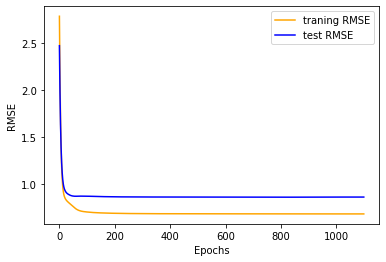

In [8]:
#task2-2
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.plot(x,y,c="orange", label="traning RMSE")
plt.plot(x,y_test,c="blue",label="test RMSE")
plt.legend()
plt.show

In [9]:
data = []
f = open("ml-latest-small/movies.csv", "r")
f  = f.readlines()
f = f[1:]
for i in range(len(f)):
  line = f[i].strip().split(",")
  #print(line)
  data.append((line[0], line[1]))
  
#print(data)
  

In [10]:
#tast 3-1 514번 User
p = []
for i in range(1, len(data)):
  p.append((i, torch.sum(Q[514] * P[i]) + mean + bias_item[i] + bias_user[514]))

p = sorted(p, key=lambda x : x[1], reverse=True)

#상위 20개 출력
for i in range(20):
  print(data[p[i][0]-1][0], data[p[i][0]-1][1])

615 Bread and Chocolate (Pane e cioccolata) (1973)
299 Priest (1994)
359 I Like It Like That (1994)
733 "Rock
7587 "Samouraï
1592 Air Bud (1997)
1128 "Fog
3438 Teenage Mutant Ninja Turtles (1990)
1593 Picture Perfect (1997)
1594 In the Company of Men (1997)
1608 Air Force One (1997)
1222 Full Metal Jacket (1987)
1600 She's So Lovely (1997)
1620 Kiss the Girls (1997)
1684 Mrs. Dalloway (1997)
410 Addams Family Values (1993)
1676 Starship Troopers (1997)
1552 Con Air (1997)
337 What's Eating Gilbert Grape (1993)
1485 Liar Liar (1997)


In [11]:
#3-2 장르 및 tag를 기준으로, 514번 user가 5점을 준 영화들을 찾고, 각각의 영화와 가장 유사한 영화를 5개씩 찾아서 id, 영화 이름, 유사도 점수 출력하기

#ratings에서 5점인 영화 찾기 -> data에 열어 놓음
df_rating = pd.read_csv("ml-latest-small/ratings.csv")
#movie
df_movie = pd.read_csv("ml-latest-small/movies.csv")
#tag
df_tag = pd.read_csv("ml-latest-small/tags.csv")


merge_table = pd.merge(df_rating, df_movie, on='movieId')
merge_table = pd.merge(merge_table,df_tag,on='movieId')
#table 정리
merge_table = merge_table[['userId_y','movieId', 'title', 'rating']]

#514번 user가 5점 준 영화만 뽑기 -> find로 저장
find = df_rating[(df_rating['rating'] == 5.0) & (df_rating['userId'] == 514)]

#영화 id 저장
movie_id = []
for i in find['movieId']:
  movie_id.append(i)
#print(movie_id)

#movies -> movies t -> tag

movie = []
for i in range(len(movies['movieId'])):
  m = movies['movieId'].iloc[i]
  for j in range(len(movie_id)):

    if(movie_id[j] == m):
      #movie title 넣어주기
      movie.append(movies['title'].iloc[i])


In [12]:
#task 3-2 이어서
#자카드 유사도로 구하기

#merge_table
merge = pd.merge(movies,t,how='outer',on='movieId')
#Nan 값 대체
merge = merge.fillna('None')
#pivot table
matrix = merge_table.pivot_table(index='userId_y', columns='title', values='rating')


# #자카드 유사도
def jaccard_similarity(s1, s2):
  if len(s1|s2) == 0:
    return 0
  return len(s1&s2) / len(s1|s2)

#유사한 영화 찾기
def find_similar_movies (input_title , matrix, n):

  result = []
  try:
    input_meta = merge.loc[ merge['title'] == input_title].iloc[0]
    #None이면 집합으로 만들어주기
    if(input_meta.tag == 'None'):
      input_meta.tag = set()
    input_set = input_meta.genres | input_meta.tag
    # print(input_set)
    result = []
    
    for this_title in matrix.columns:
      if this_title == input_title: continue
      this_meta = merge.loc[ merge[ 'title'] == this_title].iloc[0]
      this_set = this_meta.genres | this_meta.tag
      
      jaccard = jaccard_similarity(this_set, input_set)
      result.append((this_title, jaccard))
    
    result.sort(key= lambda r: r[1], reverse= True)
  except:
    pass
  return result[:n]

#결과 출력
for i in range(len(movie)):
  result = find_similar_movies(movie[i],matrix,5)
  print("MovieId : {} Movie : {}".format(movie_id[i],movie[i]))
  for title, score in result:
    print("Title : {} Score: {}".format(title,score))
  print()

MovieId : 260 Movie : Star Wars: Episode IV - A New Hope (1977)
Title : Star Wars: Episode VI - Return of the Jedi (1983) Score: 0.2857142857142857
Title : Star Wars: Episode V - The Empire Strikes Back (1980) Score: 0.25925925925925924
Title : Star Wars: Episode III - Revenge of the Sith (2005) Score: 0.23809523809523808
Title : Aliens (1986) Score: 0.2222222222222222
Title : Solo: A Star Wars Story (2018) Score: 0.17391304347826086

MovieId : 593 Movie : Silence of the Lambs, The (1991)
Title : Session 9 (2001) Score: 0.36363636363636365
Title : Identity (2003) Score: 0.2727272727272727
Title : Primal Fear (1996) Score: 0.26666666666666666
Title : Saw (2004) Score: 0.26666666666666666
Title : Copycat (1995) Score: 0.25

MovieId : 1196 Movie : Star Wars: Episode V - The Empire Strikes Back (1980)
Title : Star Wars: Episode III - Revenge of the Sith (2005) Score: 0.38461538461538464
Title : Star Wars: Episode VI - Return of the Jedi (1983) Score: 0.26666666666666666
Title : Star Wars: 

In [14]:
#task 4-1 cosine similarity를 기준으로 영화 벡터 (P혹은 Q)에서 k-means clustering 구하기 (k=1, ..., 40 까지 바꿔가면서 cost 값을 계산)
distortions = []
for i in range(1, 41):
    kmeans = KMeans(n_clusters=i).fit(preprocessing.normalize(P.detach().numpy()))
    distortions.append(kmeans.inertia_)

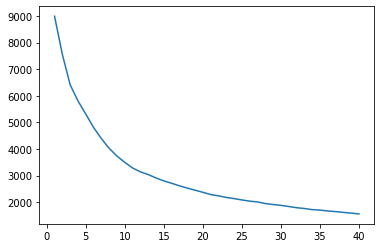

In [17]:
#task4-2 Task 4-1에서 구한 결과를 matplotlib를 활용하여 그래프로 그린 후 가장 적절해 보이는 k값 선택하기
plt.plot(range(1, 41), distortions)
plt.show()

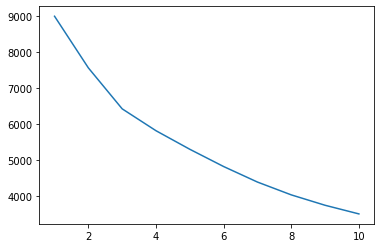

In [25]:
#task 4-2이어서 가장 적절해 보이는 k값 선택
k = 3 #3이 가장 적당한 값 같다
d = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i).fit(preprocessing.normalize(P.detach().numpy()))
    d.append(kmeans.inertia_)
plt.plot(range(1, 11), d)
plt.show()

In [30]:
#task4-3 122912번 영화(Avengers: Infinity War - Part I)와 같은 cluster에 속한 다른 영화 중 cosine similarity가 가장 높은 영화 20개를 찾아서 id, 영화 이름, 유사도 점수 출력하기
#ratings 데이터 -> pivot table로 변경, nan -> 0으로 변환
rating_matrix = merge_table.pivot_table('rating', index='userId_y', columns='title')
rating_matrix.fillna(0, inplace=True)
rating_matrix.head(2)

#rating_matrix 행렬 transpose
rating_matrix_T = rating_matrix.transpose()
rating_matrix_T.head(2)

#코사인 유사도 측정
item_sim = cosine_similarity(rating_matrix_T, rating_matrix_T)
item_sim_df = pd.DataFrame(data=item_sim, index=rating_matrix.columns, columns=rating_matrix.columns)
item_sim_df.head(2)

#유사한 영화 찾기
def find_sim_movie(df, title, top_n=20):
  title_movie = df[[title]].drop(title, axis=0)

  return title_movie.sort_values(title,ascending=False)[:top_n]
print(find_sim_movie(item_sim_df, 'Avengers: Infinity War - Part I (2018)' ))

title                                             Avengers: Infinity War - Part I (2018)
title                                                                                   
The Revenant (2015)                                                             1.000000
Self/less (2015)                                                                0.707107
Deadpool 2 (2018)                                                               0.707107
Cat Soup (Nekojiru-so) (2001)                                                   0.707107
Tetsuo, the Ironman (Tetsuo) (1988)                                             0.707107
Changeling (2008)                                                               0.707107
Taken 2 (2012)                                                                  0.707107
Chronicles of Narnia: Prince Caspian, The (2008)                                0.707107
Suicide Squad (2016)                                                            0.707107
Stranger than Fiction

In [23]:
#task 5-1  P 행렬와 Q 행렬을 합쳐 Z행렬 만들기
Z = np.concatenate((P.detach().numpy(), Q.detach().numpy()))

In [24]:
#task 5-2 Z 행렬에서 PCA 수행하여 2차원 데이터로 줄인 Zp 만들기
#2차원
pca = PCA(n_components = 2)
Zp = pca.fit_transform(torch.tensor(Z, dtype=torch.float64))

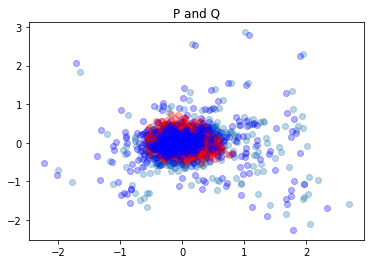

In [25]:
#task 5-3-1  P행렬과 Q행렬의 점들을 서로 다른 색으로 그리기
p_m =pca.fit_transform(torch.tensor(P[1:].tolist(), dtype=torch.float64))
q_m = pca.fit_transform(torch.tensor(Q.tolist(), dtype=torch.float64))

plt.title('P and Q')
plt.scatter(Zp[:, 0], Zp[:, 1], alpha=0.3)
plt.scatter(p_m[:, 0], p_m[:, 1],  c='r',alpha=0.3,)
plt.scatter(q_m[:, 0], q_m[:, 1], c='b', alpha=0.3)

In [41]:
#task 5-3-2 Task 3-1의 결과 점들을 다른 색으로 그려 강조하기